# Convolutionnal Neural Network (CNN) Model for preventing ArUco tag occlusion

* #### author: Mowibox (Ousmane THIONGANE)
* #### date: December 29th, 2024

### Imports

In [16]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten

## Dataset preparation 

In [17]:
filepath = r'dataset/dataset.csv'
df = pd.read_csv(filepath, sep=",", header=0).copy()

display(df.head(5))
df.info()

,filename,x20,y20,x21,y21,x22,y22,x23,y23
0,img_0.png,562.00,315.25,547.50,191.0,268.50,332.50,286.50,228.75
1,img_1.png,560.75,312.00,545.75,188.5,267.00,330.75,285.00,227.00
2,img_2.png,547.00,311.50,531.75,191.0,258.50,331.50,275.50,228.50
3,img_3.png,549.00,309.75,533.25,188.5,259.25,328.50,275.75,224.75
4,img_4.png,541.50,300.25,524.00,180.0,243.25,316.75,258.00,209.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1453 non-null   object 
 1   x20       1453 non-null   float64
 2   y20       1453 non-null   float64
 3   x21       1453 non-null   float64
 4   y21       1453 non-null   float64
 5   x22       1453 non-null   float64
 6   y22       1453 non-null   float64
 7   x23       1453 non-null   float64
 8   y23       1453 non-null   float64
dtypes: float64(8), object(1)
memory usage: 102.3+ KB


In [ ]:
WIDTH = 0.5
HEIGHT = 0.5

X, y = [], []
for idx, row in df.iterrows():
    img = cv2.imread(f"dataset/img/{row['filename']}")

    img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
    img = img / 255.0 # Data normalization
    X.append(img)

    label = row[1:].values.astype(float)  
    for i in range(0, len(label), 2):
        label[i] *= WIDTH  
        label[i + 1] *= HEIGHT  
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (1453, 240, 320, 3)
Labels shape: (1453, 8)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(1162, 240, 320, 3) (291, 240, 320, 3)


## CNN Model

In [20]:
model_cnn = Sequential()
model_cnn.add(Input(X_train[0].shape))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D(2, 2))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(8, activation='linear'))

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 238, 318, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 119, 159, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 117, 157, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 76, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 136192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │     2,179,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,064 (8.68 MB)

 Trainable params: 2,275,064 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

## Training and validation

In [21]:
model_cnn.compile(loss=MSE, optimizer=Adam(learning_rate=0.001), metrics=['mae'])

In [22]:
epochs = 20
history = model_cnn.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 17575.6484 - mae: 109.7878 - val_loss: 7066.4810 - val_mae: 66.2351
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 5139.3623 - mae: 55.2681 - val_loss: 2618.7761 - val_mae: 38.9943
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2764.4714 - mae: 40.4074 - val_loss: 2609.4253 - val_mae: 39.0466
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 2431.2864 - mae: 37.5591 - val_loss: 2181.7358 - val_mae: 35.8513
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 2241.5864 - mae: 36.0201 - val_loss: 2111.4885 - val_mae: 34.1961
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 2079.5466 - mae: 34.2287 - val_loss: 1880.0305 - val_mae: 32.9226
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 2002.0526 - mae: 33.9434 - val_loss: 1708.0502 - val_mae: 30.9703
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 1714.5948 - mae: 30.7655 - val_loss: 1847.8004 - val_mae: 33.2423
Epoch 

In [23]:
def displayLearningCurve(history, epochs: int, metric: str):
    """
    Displays the model learning curve (training & validation)

    @param history: The model history
    @param epochs: The number of epochs
    @param metric: The evaluated metric
    """
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history[metric])
    plt.plot(epoch_range, history.history[f'val_{metric}'])
    plt.title(f"Model {metric}")
    plt.ylabel(f'{metric}')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

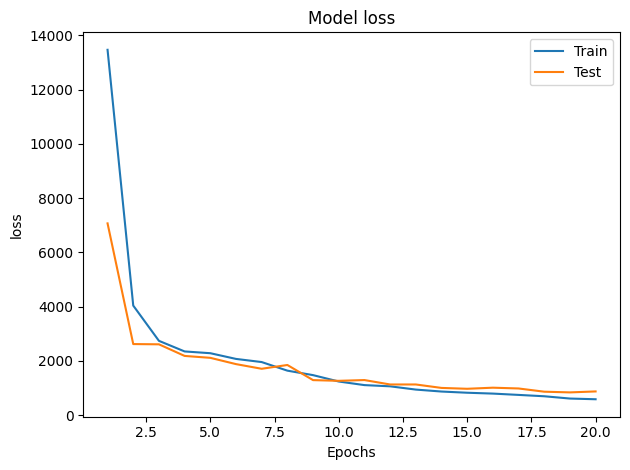

In [24]:
displayLearningCurve(history=history, epochs=epochs, metric='loss')

## Model visualisation

In [130]:
def display_img(img: np.ndarray, real_points: np.ndarray=[], predicted_points: np.ndarray=[]):
    """
    Displays the provided image on a plot
    Allows to compare real points between model prediction 

    @param img: The input image
    @param real_points: The center coordinates of the markers
    @param predicted_points: The predicted center coordinates
    """
    img =  (img*255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for i in range(0, len(real_points), 2):  
        xr, yr = real_points[i], real_points[i + 1]
        ax.scatter(xr, yr, color='cyan', label='Real Points' if i == 0 else "")

    for i in range(0, len(predicted_points), 2):  
        xp, yp = predicted_points[i], predicted_points[i + 1]
        ax.scatter(xp, yp, color='magenta', marker='x', s=100, label='Predicted Points' if i == 0 else "")
        ax.set_title("Model prediction vs real values")
    ax.legend()
    ax.imshow(img)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


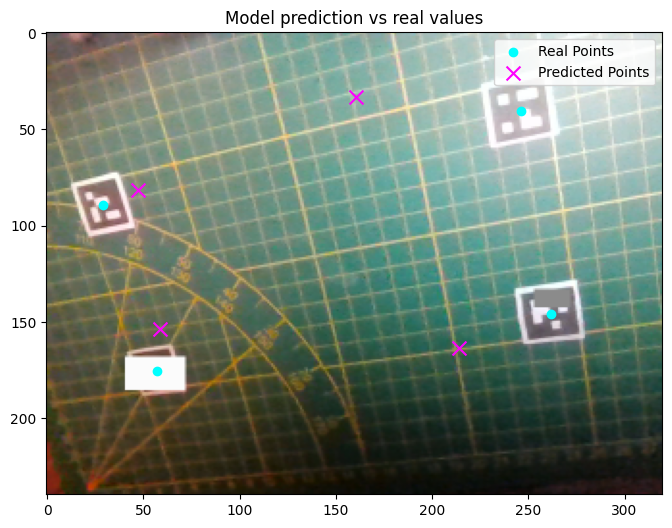

In [131]:
index = np.random.randint(0,1000)

row = df.iloc[index]
filepath = f"dataset/img/{row['filename']}"
img = cv2.imread(filepath)
img = cv2.resize(img, (int(img.shape[1]*WIDTH), int(img.shape[0]*HEIGHT)))
img = img / 255.0

real_points = row[1:].values.astype(float)  
for i in range(0, len(real_points), 2):
    real_points[i] *= WIDTH  
    real_points[i + 1] *= HEIGHT  

predicted_points = model_cnn.predict(np.expand_dims(img, axis=0))[0]

display_img(img, real_points, predicted_points)

## Saving model